In [1]:
%pip install --upgrade tensorflow keras scikit-learn opencv-python matplotlib keras_tuner keras_cv numpy seaborn

  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import tensorflow as tf
import keras

print(tf.__version__)
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2.17.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


I0000 00:00:1727117649.710092   69435 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727117649.710384   69435 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727117649.769610   69435 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727117649.769949   69435 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [5]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [6]:
import tensorflow as tf
import keras
import pandas as pd
import os
import keras_cv
import matplotlib.pyplot as plt

/home/rob/.notebook/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
csv_file = 'ham10000_data/HAM10000_metadata.csv'
img_dir = 'ham10000_data/images'
file_ext = '.jpg'

df = pd.read_csv(csv_file)

image_paths = [
    os.path.join(img_dir, image_id + file_ext)
    for image_id in df['image_id']
]

print(f"Number of images: {len(image_paths)}")
print(f"First 5 image paths: {image_paths[:5]}")

classes = sorted(df['dx'].unique())
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

labels = df['dx'].map(lambda x: classes.index(x)).values
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

print(f"Class to Index Mapping: {class_to_idx}")
print(f"Labels: {labels}")

Number of images: 10015
First 5 image paths: ['ham10000_data/images/ISIC_0027419.jpg', 'ham10000_data/images/ISIC_0025030.jpg', 'ham10000_data/images/ISIC_0026769.jpg', 'ham10000_data/images/ISIC_0025661.jpg', 'ham10000_data/images/ISIC_0031633.jpg']
Number of classes: 7
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class to Index Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Labels: [2 2 2 ... 0 0 4]


In [8]:
from IPython.display import display

display(df.head())

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [9]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

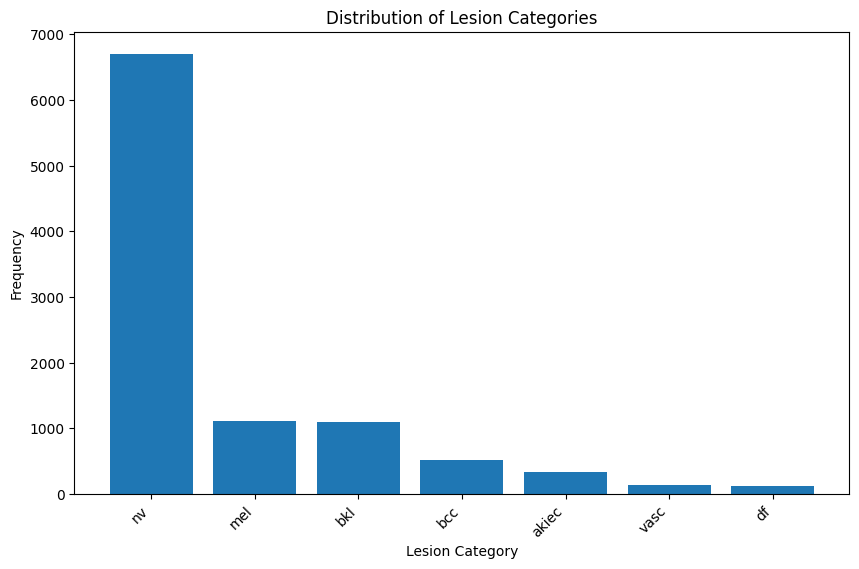

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
value_counts = df['dx'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.title('Distribution of Lesion Categories')
plt.xlabel('Lesion Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [11]:
# import matplotlib.pyplot as plt
# import random
# import tensorflow as tf

# n_samples_per_class = 5

# plt.figure(figsize=(15, len(classes) * 3))

# for class_index, class_name in enumerate(classes):
#     class_indices = [i for i, label in enumerate(labels) if label == class_index]

#     random_class_indices = random.sample(class_indices, min(n_samples_per_class, len(class_indices)))

#     for i, idx in enumerate(random_class_indices):
#         img_path = image_paths[idx]
#         label = labels[idx]

#         img = tf.io.read_file(img_path)
#         img = tf.image.decode_jpeg(img, channels=3)

#         # Display image
#         plt.subplot(len(classes), n_samples_per_class, class_index * n_samples_per_class + i + 1)
#         plt.imshow(img)
#         plt.title(f"Class: {class_name}")
#         plt.axis('off')

# plt.tight_layout()
# plt.show()


In [12]:
def load_and_preprocess_image(image_id, label):
    # Load and preprocess the image
    image = tf.io.read_file(image_id)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # ResNet expects 224x224 images
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing for ResNet

    return image, label


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

train_paths = []
train_labels = []
val_paths = []
val_labels = []

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(image_paths, labels):
    train_paths = [image_paths[i] for i in train_index]
    train_labels = labels[train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = labels[val_index]

print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

Training set size: 8012
Validation set size: 2003


I0000 00:00:1727117652.057606   69435 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727117652.057926   69435 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727117652.058129   69435 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727117652.058309   69435 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [14]:
batch_size = 4

train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()

val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache()


In [15]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

In [16]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [17]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

class_counts = np.bincount(train_labels)
total_counts = np.sum(class_counts)
class_prior = class_counts / total_counts

class BilinearPooling(layers.Layer):
    def __init__(self):
        super(BilinearPooling, self).__init__()

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)

        # inputs shape: (batch_size, height, width, channels)
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        channels = inputs.shape[-1]  # Static shape (channels)

        # Reshape input to (batch_size, height * width, channels)
        reshaped = tf.reshape(inputs, [batch_size, height * width, channels])

        # Compute the outer product (bilinear pooling)
        bilinear_features = tf.matmul(reshaped, reshaped, transpose_a=True) / tf.cast(height * width, tf.float32)

        # Flatten the bilinear pooled features (Explicit shape)
        bilinear_flat = tf.reshape(bilinear_features, [batch_size, channels * channels])

        # Normalize using Signed Square Root and L2 normalization (optional)
        bilinear_flat = tf.sign(bilinear_flat) * tf.sqrt(tf.abs(bilinear_flat) + 1e-10)
        bilinear_flat = tf.nn.l2_normalize(bilinear_flat)

        return bilinear_flat

def build_model(hp):
    strategy = tf.distribute.MirroredStrategy()

    with strategy.scope():
        base_model = keras.applications.resnet.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3),
            pooling=None
        )

        base_model.trainable = False

        inputs = keras.Input(shape=(224, 224, 3))  # Keep input size
        x = base_model(inputs, training=False)

        # Optionally reduce channels before bilinear pooling
        x = keras.layers.Conv2D(256, (1, 1), activation='relu')(x)

        # Apply Bilinear Pooling
        x = BilinearPooling()(x)

        # Flatten the output to ensure fully defined shape
        x = layers.Flatten()(x)  # Use Flatten to avoid dynamic dimensions

        # Ensure the shape is known before passing to Dense layer
        x = keras.layers.Dense(512, activation='relu')(x)

        # Output Layer
        output_bias = np.log(class_prior)
        outputs = keras.layers.Dense(
            num_classes,
            activation='softmax',
            bias_initializer=keras.initializers.Constant(output_bias),
        )(x)

        model = keras.Model(inputs, outputs)

        learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5, 1e-6])
        optimizer = keras.optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=hp.Float('weight_decay', min_value=0.0, max_value=0.01, step=0.001)
        )

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model


In [18]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='random_search',
    project_name='resnet-50-covariance-pooling-2'
)

tuner.search_space_summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Search space summary
Default search space size: 2
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}
weight_decay (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.01, 'step': 0.001, 'sampling': 'linear'}


In [19]:
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
)

Trial 10 Complete [00h 24m 07s]
val_accuracy: 0.8233532905578613

Best val_accuracy So Far: 0.8283433318138123
Total elapsed time: 04h 02m 52s


In [20]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameters:
Best Learning Rate: {best_hps.get('learning_rate')}
Best Weight Decay: {best_hps.get('weight_decay')}
""")




Hyperparameters:
Best Learning Rate: 0.0001
Best Weight Decay: 0.007



In [21]:
from keras.callbacks import ModelCheckpoint

best_model = tuner.hypermodel.build(best_hps)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=1e-4,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        filepath='models/resnet50-ham10000.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
]

history = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=callbacks
)

best_model.save('models/resnet50-ham10000-final.keras')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/500
INFO:tensorflow:Collective all_reduce tensors: 6 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7086 - loss: 0.8486
Epoch 1: val_loss improved from inf to 0.61756, saving model to models/resnet50-ham10000.keras
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 156s 74ms/step - accuracy: 0.7086 - loss: 0.8485 - val_accuracy: 0.7735 - val_loss: 0.6176 - learning_rate: 1.0000e-04
Epoch 2/500
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7919 - loss: 0.5630
Epoch 2: val_loss improved from 0.61756 to 0.54327, saving model to models/resnet50-ham10000.keras
2003/2003 ━━━━━━━━━━━━━━━━━━━━ 144s 72ms/step - accuracy: 0.7919 - loss: 0.5630 - val_accuracy: 0.7974 - val_loss: 0.5433 - learning_rate: 1.0000e-04
Epoch 3/500
2003/

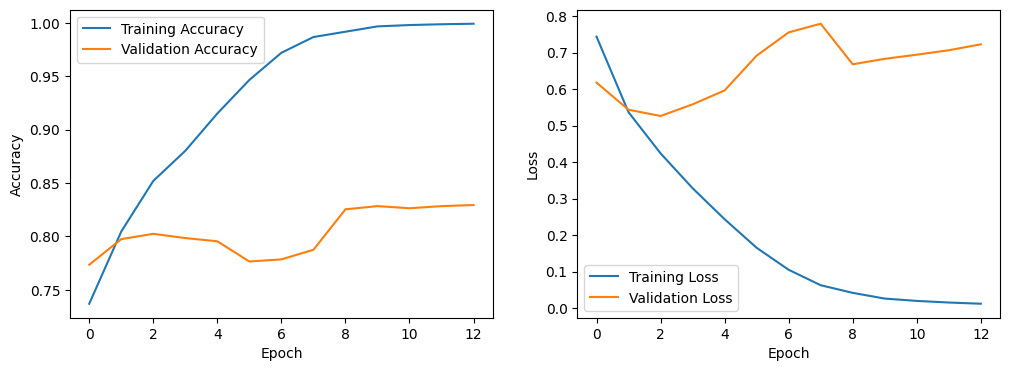

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []

def get_predictions(dataset):
    for images, labels in dataset:
        predictions = best_model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Get predictions for validation dataset
y_true, y_pred = get_predictions(val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [24]:
# Classification Report

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

       akiec       0.56      0.57      0.56        65
         bcc       0.70      0.55      0.62       103
         bkl       0.61      0.67      0.64       220
          df       1.00      0.17      0.30        23
         mel       0.53      0.66      0.59       223
          nv       0.92      0.90      0.91      1341
        vasc       0.91      0.71      0.80        28

    accuracy                           0.81      2003
   macro avg       0.75      0.61      0.63      2003
weighted avg       0.82      0.81      0.81      2003



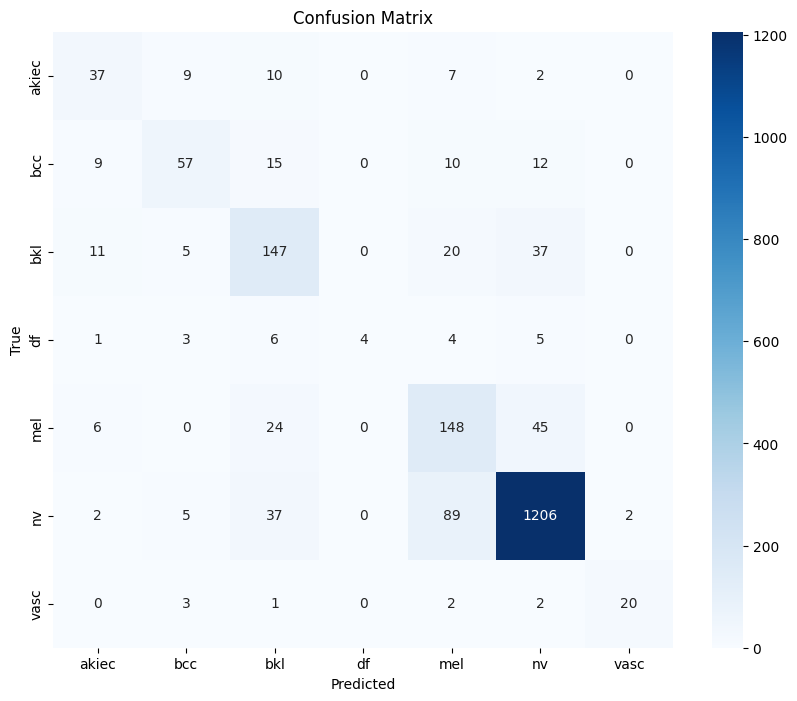

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

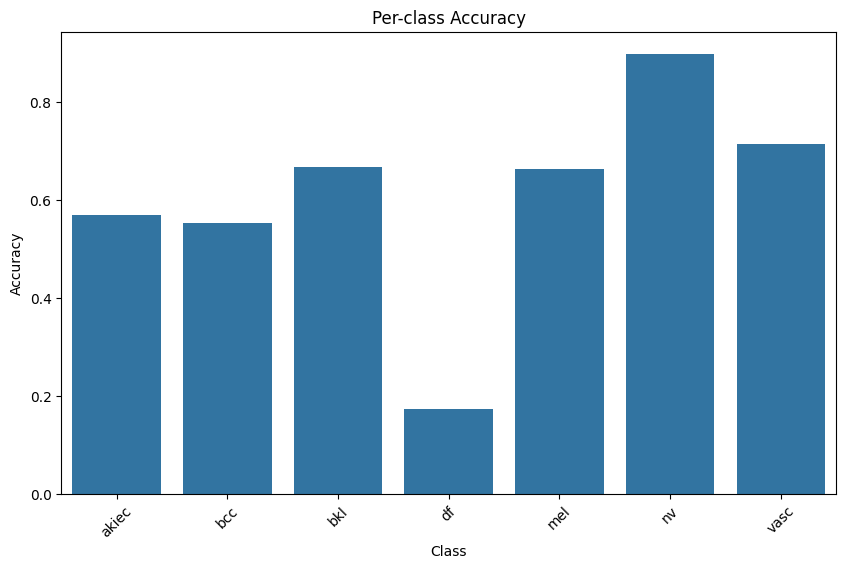

In [26]:
# Per-class Accuracy Plot
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=class_accuracies)
plt.title('Per-class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

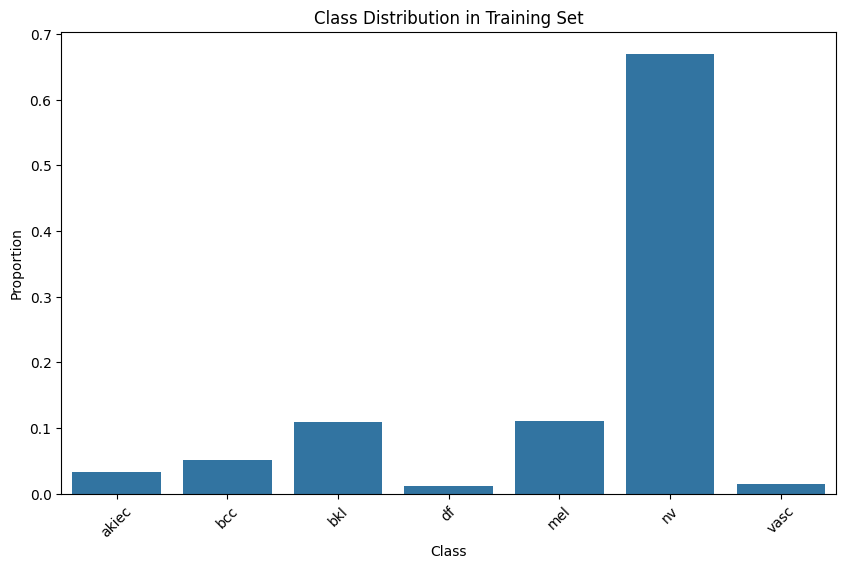

In [27]:
# Class distribution in training set
train_labels = np.concatenate([labels.numpy() for _, labels in train_dataset])
train_class_dist = np.bincount(train_labels) / len(train_labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=train_class_dist)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()